# DATASET
Dataset contains 6 tile  with different images
## LEGEND
the labels are:
- Building (#3C1098)
- Land (#8429F6)
- Road (#6EC1E4)
- Vegetation (#FEDD3A)
- Water (#E2A929)
- Unlabeled (#9B9B9B)

they are encoded in exadecimal 
### SOURCE
from: https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery
'''

In [1]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `tf.keras` framework.


In [2]:
PATH  = "/Users/simoneboesso/Desktop/RemoteSensing/Semantic segmentation dataset/"

In [3]:
from SemanticSegmentation_scripts.PatchesGenerator import PatchesGenerator
PATCH_GENERATOR = PatchesGenerator(256,PATH)
PATCH_GENERATOR.crop_image_creating()
PATCH_GENERATOR.crop_mask_creating()

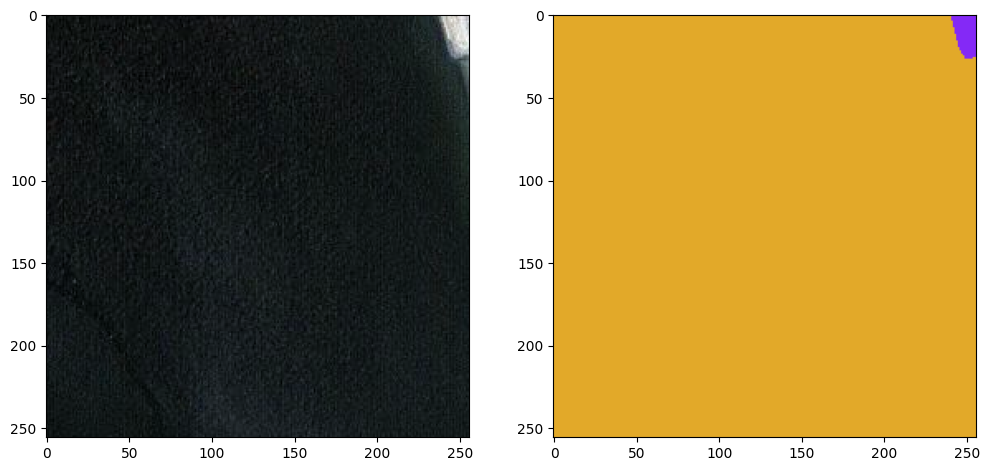

In [4]:
PATCH_GENERATOR.check()

In [5]:
from SemanticSegmentation_scripts.HEX_to_RGB import HEX_to_RGB,RGB_to_2DLabels


In [6]:
RGB_CONVERTOR = HEX_to_RGB()
HEXLabels = ["#3C1098", "#8429F6", "#6EC1E4", "#FEDD3A", "#E2A929","#9B9B9B"]
LabelsList = []
for el in HEXLabels:
    LabelsList.append(RGB_CONVERTOR.convert(el))

In [7]:
LabelsList

[array([ 60,  16, 152]),
 array([132,  41, 246]),
 array([110, 193, 228]),
 array([254, 221,  58]),
 array([226, 169,  41]),
 array([155, 155, 155])]

In [8]:
LABEL_CONVERTOR = RGB_to_2DLabels(LabelsList)
mask_dataset = PATCH_GENERATOR.mask_dataset
image_dataset = PATCH_GENERATOR.image_dataset

In [9]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = LABEL_CONVERTOR.convert(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

In [10]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


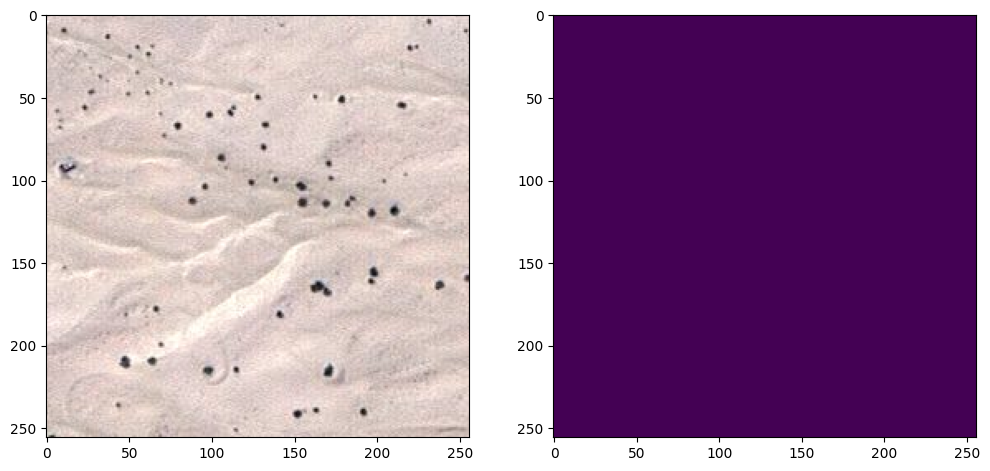

In [11]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

# Modelling section

In [12]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

## NEXT STEPS:

- Grid search for hyperparameter tuning following university procedure;
- review U-net concepts
- compare with other pretrained models


# Choosing hyperparameters

1. Check initial Loss (Turn off weight decay, sanity check loss at initialization)
2. Overfit a small sample (try to train to 100% training accuracy on a small sample of training data, approx. 5-10 minibatches)
    1. Fiddle with architecture, learning rate, weight initialization;
    2. some common problems:
        1. Loss is not going down: LR too low, or bad initialization;
        2. Loss explodes to Inf or Nan: LR too high, bad initialization
3. Use all the training data, turn on small weight decay, find the learning rate that makes the loss drop significantly  withing 100 iterations ( use the same architecture obtained in the previous step);
    1. good learning rates to try: 1e-1, 1e-2, 1e-3, 1e-4
4. choose few values of learning rate and weight decay around what worked for the previous step and then train these few models for 1-5 epochs
    1. good weight decay to try: 1e-4, 1e-5, 0
5. Pick the best models from Step 4, train them for longer 10-20 epochs WITHOUT learning rate decay.
6. Measure their performances using loss and accuracy curves
7. Go back to step 5 if needed (refine grid search)

In [14]:
import wandb
!wandb login b4472d786069da7024bb49f356658d721ee2186a
# https://docs.wandb.ai/quickstart

wandb: Appending key for api.wandb.ai to your netrc file: /Users/simoneboesso/.netrc


In [25]:
_, sample_imgs, y_, sample_labels = train_test_split(X_train, y_train, test_size = 0.005, random_state = 42)

In [28]:
from SemanticSegmentation_scripts.Multi_unet_model import multi_unet_model, jacard_coef  

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

1. Check initial loss

In [ ]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=1, 
                    shuffle=False)

2. Overfit a small sample

In [26]:
sample_imgs.shape

(6, 256, 256, 3)

In [32]:
history2 = model.fit(sample_imgs, sample_labels, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=150, 
                    shuffle=False)

Epoch 1/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step - accuracy: 0.8369 - loss: 0.0099
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step - accuracy: 0.8408 - loss: 0.0098
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step - accuracy: 0.8454 - loss: 0.0095
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step - accuracy: 0.8440 - loss: 0.0094
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step - accuracy: 0.8484 - loss: 0.0092
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step - accuracy: 0.8534 - loss: 0.0091
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step - accuracy: 0.8570 - loss: 0.0089
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step - accuracy: 0.8526 - loss: 0.0089
Epoch 9/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step - accuracy: 0.8592 - loss: 0.0084
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step - accuracy: 0.8609 - loss: 0.0083
Epoch 11/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step - accuracy: 0.8591 - loss: 0.0082
Epoch 12/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step - accuracy:

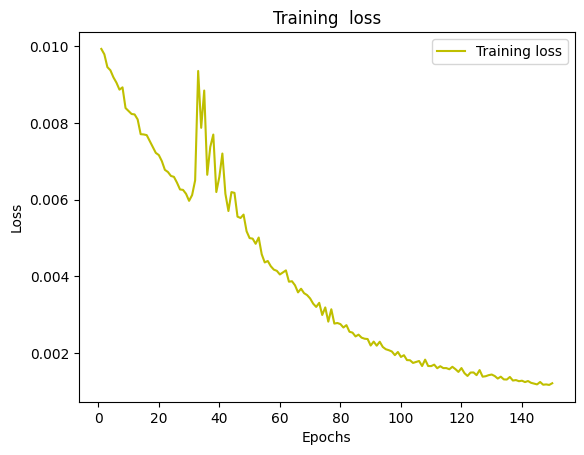

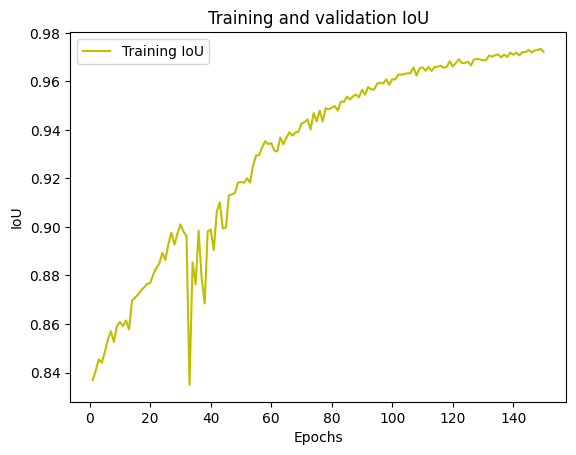

In [34]:
history = history2
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training  loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()